# LFSR design uniplor

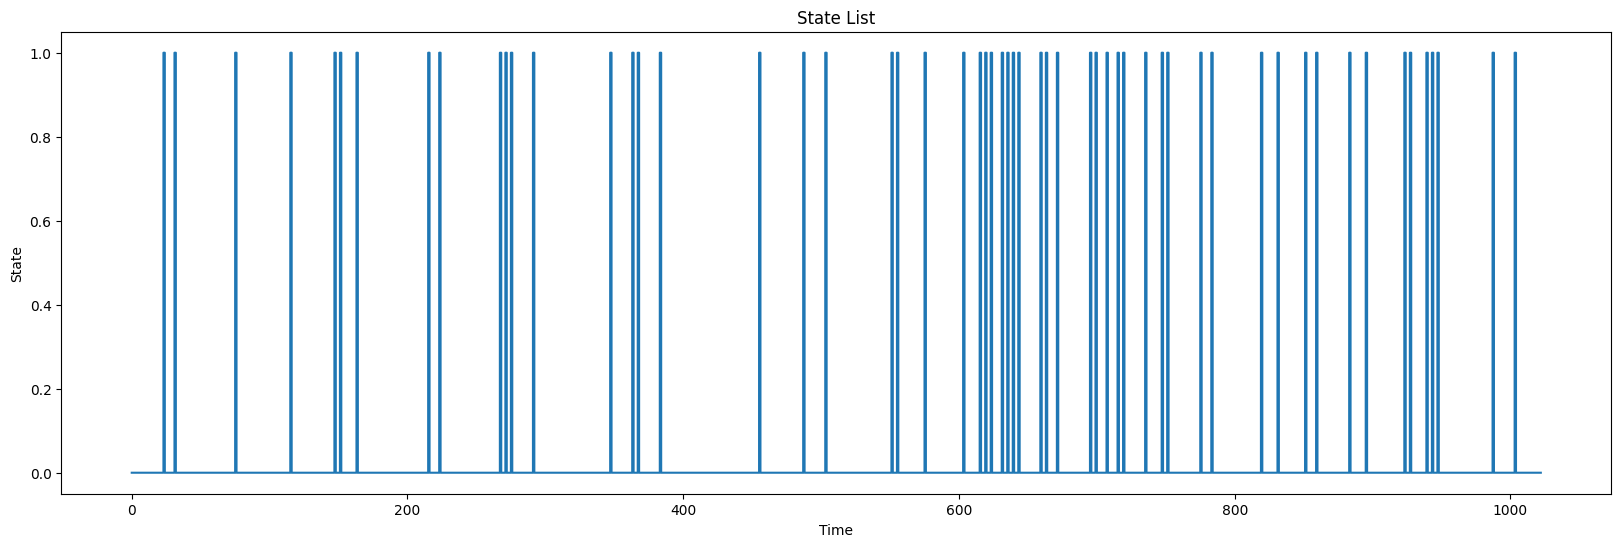

,x1,w1,x2,w2,x3,w3,b,sum(wx)+b,tanh
real,0.010000,0.010000,0.010000,0.001000,0.010000,0.010000,0.200000,0.200210,0.197577
SC,0.009775,0.009775,0.009775,0.000978,0.009775,0.009775,0.199413,0.222874,1.000000
error %,2.248289,2.248289,2.248289,2.248289,2.248289,2.248289,0.293255,11.320064,406.131451


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def lfsr_zhu(seed, target, bitstream_length, bit1=7, bit2=10, isprint=False):
    lfsr = seed.copy()
    output_stream = np.zeros(bitstream_length, dtype=int)

    target_10 = target * (2**10-1) # 1023

    # do xor on bit1 and bit2
    for i in range(bitstream_length):
        xorbit = lfsr[10-bit1] ^ lfsr[10-bit2]
        # shift left
        lfsr = np.roll(lfsr, -1)
        # replace the right bit with xor result
        lfsr[9] = xorbit
        # compare with target
        lfsr_val = int(''.join([str(i) for i in lfsr]), 2) # array->binary->int
        if isprint: print(lfsr_val)

        if lfsr_val <= target_10:
            output_stream[i] = 1
        else:
            output_stream[i] = 0
    return output_stream

def SC_multiply(x: np.array, w: np.array):
    return x & w

def SC_add(wx1, wx2, wx3, b):
    xw123b = np.zeros(wx1.shape[0], dtype=int)
    counter = 0
    for i in range(wx1.shape[0]):
        if counter == 0:
            xw123b[i] = wx1[i]
        elif counter == 1:
            xw123b[i] = wx2[i]
        elif counter == 2:
            xw123b[i] = wx3[i]
        elif counter == 3:
            xw123b[i] = b[i]
        counter += 1
        if counter == 4:
            counter = 0
    return xw123b
     
def tanh_FSM(stm):
    state = 0
    state_list = []
    output_stream = np.zeros(stm.shape[0], dtype=int)
    for i in range(stm.shape[0]):
        if stm[i] == 0:
            state = max(0, state - 1)
            state_list.append(state)
        else:
            state = min(7, state + 1)
            state_list.append(state)
        output_stream[i] = 0 if state >= 4 else 1
    return output_stream, state_list

seed1 = np.array([0,0,0,1,1,1,0,1,0,0])
seed2 = np.array([1,1,1,0,0,0,1,0,1,0])
bitstream_length = 1023
x1_tar, x2_tar, x3_tar = 0.01, 0.01, 0.01
w1_tar, w2_tar, w3_tar = 0.01, 0.001, 0.01
b_tar = 0.2
x1_stm = lfsr_zhu(seed=seed1, target=x1_tar, bitstream_length=bitstream_length)
x2_stm = lfsr_zhu(seed=seed2, target=x2_tar, bitstream_length=bitstream_length)
x3_stm = lfsr_zhu(seed=seed1, target=x3_tar, bitstream_length=bitstream_length)
w1_stm = lfsr_zhu(seed=seed2, target=w1_tar, bitstream_length=bitstream_length)
w2_stm = lfsr_zhu(seed=seed1, target=w2_tar, bitstream_length=bitstream_length)
w3_stm = lfsr_zhu(seed=seed2, target=w3_tar, bitstream_length=bitstream_length)
b_stm = lfsr_zhu(seed=seed1, target=b_tar, bitstream_length=bitstream_length)
x1_stm_v, x2_stm_v, x3_stm_v = x1_stm.mean(), x2_stm.mean(), x3_stm.mean()
w1_stm_v, w2_stm_v, w3_stm_v = w1_stm.mean(), w2_stm.mean(), w3_stm.mean()
b_stm_v = b_stm.mean()

cols = ['x1','w1','x2','w2','x3','w3','b','sum(wx)+b','tanh']
rows = ['real', 'SC']
df = pd.DataFrame(columns=cols)

# write real values
df.loc['real'] = [x1_tar, w1_tar, x2_tar, w2_tar, x3_tar, w3_tar, b_tar, x1_tar*w1_tar+x2_tar*w2_tar+x3_tar*w3_tar+b_tar, np.tanh(x1_tar*w1_tar+x2_tar*w2_tar+x3_tar*w3_tar+b_tar)]


wx1 = SC_multiply(x1_stm, w1_stm)
wx2 = SC_multiply(x2_stm, w2_stm)
wx3 = SC_multiply(x3_stm, w3_stm)
wx123b = SC_add(wx1, wx2, wx3, b_stm)
tanh_stm, statelis = tanh_FSM(wx123b)

df.loc['SC'] = [x1_stm_v, w1_stm_v, x2_stm_v, w2_stm_v, x3_stm_v, w3_stm_v, b_stm_v, wx123b.mean()*4, tanh_stm.mean()]

df.loc['error %'] = np.abs(df.loc['real'] - df.loc['SC']) / df.loc['real'] * 100

# plt state_list, fig size (20, 10)
plt.figure(figsize=(20,6))
plt.plot(statelis, drawstyle='steps-post')
plt.title('State List')
plt.xlabel('Time') 
plt.ylabel('State')
plt.show()

df

# LFSR Bipolar

In [17]:
# LFSR bioplor
def lfsr_zhu_biop(seed: np.array, target: float, 
                  bitstream_length=1023, bit1=7, bit2=10, isprint=False):
    lfsr = seed.copy()
    output_stream = np.zeros(bitstream_length, dtype=int)
    # convert target
    biop_tar = (target+1)/2 # -1~1 -> 0~1

    target_10 = biop_tar * 1023

    # do xor on bit1 and bit2
    for i in range(bitstream_length):
        xorbit = lfsr[10-bit1] ^ lfsr[10-bit2]
        # shift left
        lfsr = np.roll(lfsr, -1)
        # replace the right bit with xor result
        lfsr[9] = xorbit
        # compare with target
        lfsr_val = int(''.join([str(i) for i in lfsr]), 2) # array->binary->int
        if isprint: print(lfsr_val)

        if lfsr_val <= target_10:
            output_stream[i] = 1
        else:
            output_stream[i] = 0

    return output_stream

def SC_multiply_bipo(x1: np.array, x2: np.array):
    output = np.zeros(x1.shape[0], dtype=int)
    # func for ~XOR
    for i in range(x1.shape[0]):
        if x1[i] == x2[i]:
            output[i] = 1
        else:
            output[i] = 0
    return output

def SC_add(wx1:np.array, wx2:np.array, wx3:np.array, b:np.array):
    xw123b = np.zeros(wx1.shape[0], dtype=int)
    counter = 0
    for i in range(wx1.shape[0]):
        if counter == 0:
            xw123b[i] = wx1[i]
        elif counter == 1:
            xw123b[i] = wx2[i]
        elif counter == 2:
            xw123b[i] = wx3[i]
        elif counter == 3:
            xw123b[i] = b[i]
        counter += 1
        if counter == 4:
            counter = 0
    return xw123b

def create_from_seed(seed1: int):
    seed1_bin_str = format(seed1, '010b')
    seed1 = np.array([int(bit) for bit in seed1_bin_str])
    return seed1

def tanh_FSM(stm):
    state = 0
    state_list = []
    output_stream = np.zeros(stm.shape[0], dtype=int)
    for i in range(stm.shape[0]):
        if stm[i] == 0:
            state = max(0, state - 1)
            state_list.append(state)
        else:
            state = min(7, state + 1)
            state_list.append(state)
        output_stream[i] = 1 if state >= 4 else 0
    return output_stream, state_list

cols = ['x1','w1','x2','w2','x3','w3','b','sum(wx)+b','tanh']
rows = ['real', 'SC']
df = pd.DataFrame(columns=cols)

# test LFSR bipolar
seed_6 = np.random.randint(0, 1023, 6)
seed1_dec, seed2_dec, seed3_dec, seed4_dec, seed5_dec, seed6_dec = seed_6[0], seed_6[1], seed_6[2], seed_6[3], seed_6[4], seed_6[5]
seed1, seed2, seed3, seed4, seed5, seed6 = create_from_seed(seed1_dec), create_from_seed(seed2_dec), create_from_seed(seed3_dec), create_from_seed(seed4_dec), create_from_seed(seed5_dec), create_from_seed(seed6_dec)

x1_tar, x2_tar, x3_tar = -0.5, 0.3, 0.1
w1_tar, w2_tar, w3_tar = 0.2, -0.4, 0.6
b_tar = -0.1
x1_stm, x2_stm, x3_stm = lfsr_zhu_biop(seed1, x1_tar), lfsr_zhu_biop(seed2, x2_tar), lfsr_zhu_biop(seed3, x3_tar)
w1_stm, w2_stm, w3_stm = lfsr_zhu_biop(seed4, w1_tar), lfsr_zhu_biop(seed5, w2_tar), lfsr_zhu_biop(seed6, w3_tar)
b_stm = lfsr_zhu_biop(seed1, b_tar)
x1_stm_v, w1_stm_v, x2_stm_v, w2_stm_v, x3_stm_v, w3_stm_v, b_stm_v = x1_stm.mean()*2-1, w1_stm.mean()*2-1, x2_stm.mean()*2-1, w2_stm.mean()*2-1, x3_stm.mean()*2-1, w3_stm.mean()*2-1, b_stm.mean()*2-1

wx1, wx2, wx3 = SC_multiply_bipo(x1_stm, w1_stm), SC_multiply_bipo(x2_stm, w2_stm), SC_multiply_bipo(x3_stm, w3_stm)
wx1_v, wx2_v, wx3_v = wx1.mean()*2-1, wx2.mean()*2-1, wx3.mean()*2-1

wx123b = SC_add(wx1, wx2, wx3, b_stm)
wx123b_v = wx123b.mean()*2-1

tanh_stm, state_list = tanh_FSM(wx123b)
tanh_stm_v = tanh_stm.mean()*2-1

df.loc['real'] = [x1_tar, w1_tar, x2_tar, w2_tar, x3_tar, w3_tar, b_tar, x1_tar*w1_tar+x2_tar*w2_tar+x3_tar*w3_tar+b_tar, np.tanh(x1_tar*w1_tar+x2_tar*w2_tar+x3_tar*w3_tar+b_tar)]
df.loc['SC'] = [x1_stm_v, w1_stm_v, x2_stm_v, w2_stm_v, x3_stm_v, w3_stm_v, b_stm_v, wx123b_v*4, tanh_stm_v]
df.loc['err%'] = [abs(df.loc['real'][i]-df.loc['SC'][i])/abs(df.loc['real'][i])*100 for i in range(len(cols))]
df


,x1,w1,x2,w2,x3,w3,b,sum(wx)+b,tanh
real,-0.500000,0.200000,0.300000,-0.400000,0.100000,0.600000,-0.100000,-0.260000,-0.254296
SC,-0.501466,0.198436,0.298143,-0.401760,0.098729,0.599218,-0.100684,-0.277615,-0.251222
err%,0.293255,0.782014,0.619094,0.439883,1.270772,0.130336,0.684262,6.774945,1.208687


# Use optuna to find best seed, for x1 x2 in range of (-1,1)

In [ ]:
import numpy as np
import optuna

def create_best_seed(tar1:float, tar2:float, seed1_dec:int, seed2_dec:int):

    # Convert to 10-bit binary string
    seed1_bin_str = format(seed1_dec, '010b')
    seed2_bin_str = format(seed2_dec, '010b')
    # Convert binary strings to numpy arrays
    seed1 = np.array([int(bit) for bit in seed1_bin_str])
    seed2 = np.array([int(bit) for bit in seed2_bin_str])

    bitstream_length = 1023

    x1_stm = lfsr_zhu_biop(seed=seed1, target=tar1, bitstream_length=bitstream_length)
    x2_stm = lfsr_zhu_biop(seed=seed2, target=tar2, bitstream_length=bitstream_length)
    x1_stm_v, x2_stm_v = x1_stm.mean()*2-1, x2_stm.mean()*2-1

    x1x2 = SC_multiply_bipo(x1_stm, x2_stm)
    x1x2_v = x1x2.mean()*2-1

    error = np.abs(x1x2_v - tar1*tar2) / (tar1*tar2) * 100

    return error

def objective(trial, tar1, tar2):
    # Suggest seeds (as integers) to use
    seed1_dec = trial.suggest_int('seed1_dec', 0, 1023)
    seed2_dec = trial.suggest_int('seed2_dec', 0, 1023)

    # Call your function with the suggested seeds
    error = create_best_seed(tar1, tar2, seed1_dec, seed2_dec)

    return error

# Initialize 3D array to store best seeds
best_seeds = np.zeros((1000, 1000, 2))

# Iterate over all combinations of tar1 and tar2
for i, tar1 in enumerate(np.arange(-1, 1, 0.01)):
    for j, tar2 in enumerate(np.arange(-1, 1, 0.01)):
        # Create a study object and optimize the objective function
        study = optuna.create_study()
        study.optimize(lambda trial: objective(trial, tar1, tar2), n_trials=100)

        # Store the best seeds
        best_seeds[i, j, 0] = study.best_params['seed1_dec']
        best_seeds[i, j, 1] = study.best_params['seed2_dec']
        print('tar1:', tar1, 'tar2:', tar2, 'finished')